minion1016 WFD depth for 1yr (defined as all nights<night=365) contains only 6.3% of the WFD 10yr visits, not 10%. 

Here, the idea is to check the median depth in each band for all nights<night=521 (by which we have 10% of WFD 10yr visits in minion1016).

In [1]:
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as mafUtils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import healpy as hp
from collections import OrderedDict
import pandas as pd
from IPython.display import display
from copy import deepcopy

In [2]:
from os.path import expanduser
home = expanduser("~")

In [3]:
from mafContrib import newDitherStackers as myStackers   # my stackers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as mafUtils
import lsst.sims.maf.maps as maps

In [4]:
# simdata datapath
mainDir= home+'/lsstData/'
dbpath=mainDir+'minion_1016_sqlite_new_dithers.db'   # new afterburner output

Run coadd analysis with data for all nights upto specific nightCutOff.

In [5]:
def coaddM5(dbpath, outDir, nightCutOff, filterBand, runName, nside ):
    # includes dust extinction. run for RepulsiveRandomDitherFieldPerVisit only.
    opsdb = db.OpsimDatabase(dbpath)
    resultsDb = db.ResultsDb(outDir=outDir)

    # set up sql constraint
    propIds, propTags = opsdb.fetchPropInfo()
    wfdWhere = mafUtils.createSQLWhere('WFD', propTags)
    sqlconstraint  = wfdWhere + ' and night <= ' + str(nightCutOff) + ' and filter=="' + filterBand + '"'
    
    # set up slicer/stacker
    slicer= {}
    stackerList= {}

    stackerList['RepulsiveRandomDitherFieldPerVisit'] = [myStackers.RepulsiveRandomDitherFieldPerVisitStacker(randomSeed=1000)]
    slicer['RepulsiveRandomDitherFieldPerVisit']= slicers.HealpixSlicer(lonCol='repulsiveRandomDitherFieldPerVisitRa', 
                                                                        latCol='repulsiveRandomDitherFieldPerVisitDec', nside=nside, useCache=False)

    # include dust extinction when calculating the co-added depth
    coaddMetric = metrics.ExgalM5(lsstFilter= filterBand) 
    dustMap = maps.DustMap(interp=False, nside= nside)   # include dustMap; actual in/exclusion of dust is handled by the galaxyCountMetric

    # set up the bundle
    coaddBundle= {}    
    for dither in slicer:
        coaddBundle[dither] = metricBundles.MetricBundle(coaddMetric, slicer[dither], sqlconstraint, 
                                                             stackerList= stackerList[dither], 
                                                             runName=runName, metadata= dither, mapsList=[dustMap]) 
    cGroup = metricBundles.MetricBundleGroup(coaddBundle, opsdb, outDir=outDir, resultsDb=resultsDb,saveEarly= False)
    cGroup.runAll()
    
    return coaddBundle[dither]

In [6]:
# set up
outDir= mainDir
nightCutOff= 521
runName= 'minion1016'
nside= 256

In [7]:
coaddBundles= {}
for filterBand in ['u', 'g', 'r', 'i', 'z', 'y']:
    coaddBundles[filterBand]= coaddM5(dbpath, outDir, nightCutOff, filterBand, runName,nside)
    print('')

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database with constraint propID = 54 and night <= 521 and filter=="u"
Found 10706 visits
Running:  ['RepulsiveRandomDitherFieldPerVisit']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database with constraint propID = 54 and night <= 521 and filter=="g"
Found 16797 visits
Running:  ['RepulsiveRandomDitherFieldPerVisit']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database with constraint propID = 54 and night <= 521 and filter=="r"
Found 35115 visits
Running:  ['RepulsiveRandomDitherFieldPerVisit']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Healpix slicer using NSIDE=256, approximate resoluti

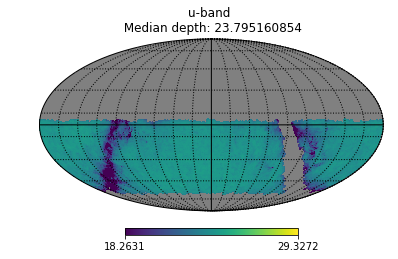

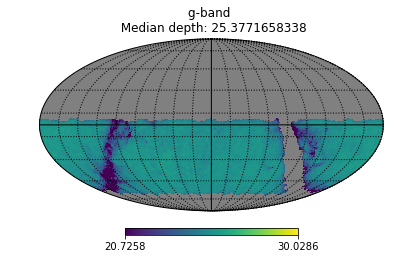

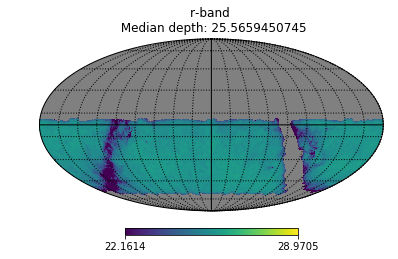

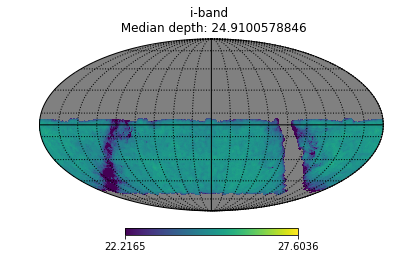

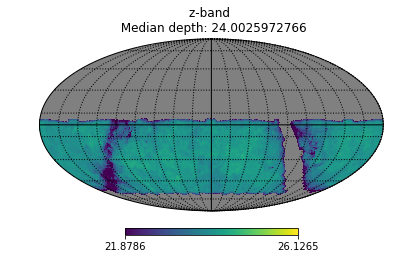

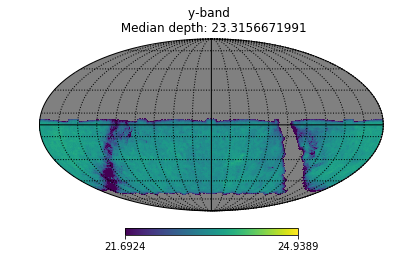

In [8]:
# Plot the skymaps.
medians= {}
for band in coaddBundles.keys():
    inSurveyIndex= np.where(coaddBundles[band].metricValues.mask == False)[0]
    median= np.median(coaddBundles[band].metricValues.data[inSurveyIndex])
    stddev= np.std(coaddBundles[band].metricValues.data[inSurveyIndex])
    
    medians[band]= median
    colorMin= median-2.5*stddev
    colorMax= median+2.5*stddev
        
    plt.clf()
    hp.mollview(coaddBundles[band].metricValues, 
                min= colorMin, max= colorMax, 
                title= '%s-band \n Median depth: %s'%(band, median),
                flip= 'astro', 
                rot=(0,0,0),cbar=True, )
    
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(5, 5)
    plt.show()

In [9]:
print('Median depths after night=521: ')
print(medians)

Median depths after night=521: 
{'u': 23.795160853950424, 'g': 25.377165833786055, 'r': 25.565945074516804, 'i': 24.910057884620223, 'z': 24.002597276614527, 'y': 23.315667199085482}
